In this notebook, we generate a common mask by combining Planck 2018 CMB lensing and Legacy Surveys DR9 footprints.

In [1]:
import healpy as hp
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Define $\ell_{\rm max}$ and `NSIDE` of the combined mask. 

In [2]:
NSIDE_OUT = 1024
LMAX_OUT = 3 * NSIDE_OUT - 1

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


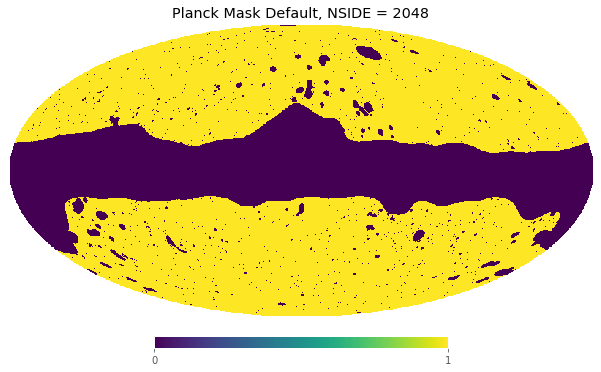

In [3]:
#cmb lensing mask
planck_mask_gal = hp.fitsfunc.read_map("../dat/planck-lensing-mask.fits") 
hp.mollview(planck_mask_gal, title = "Planck Mask Default, NSIDE = 2048")

Apodize lensing mask with a Gaussian beam with size comparable to angular scale of `LMAX_OUT`

In [4]:
#apodize cmb lensing mask 
planck_mask_gal_apodized = np.clip(a = hp.smoothing(planck_mask_gal, fwhm=np.radians(180/NSIDE_OUT), 
                                                    pol=False), 
                                   a_min=0., a_max=1.)

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 4.478845 arcmin (0.001303 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 10.546875 arcmin
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


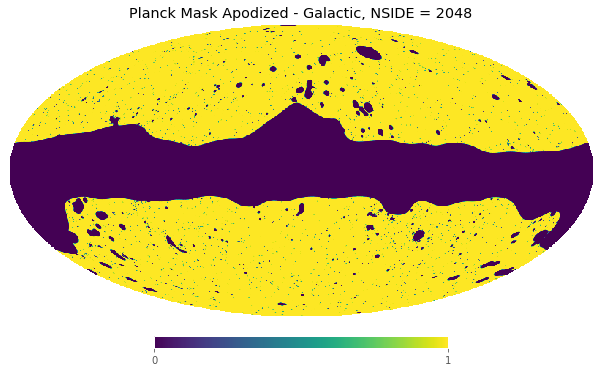

In [5]:
hp.mollview(planck_mask_gal_apodized, title = "Planck Mask Apodized - Galactic, NSIDE = 2048")

Difference between apodized map and original map

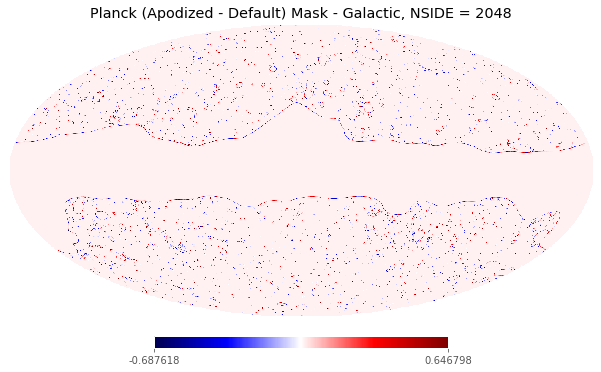

In [6]:
hp.mollview(planck_mask_gal_apodized - planck_mask_gal, cmap = 'seismic', 
            title = "Planck (Apodized - Default) Mask - Galactic, NSIDE = 2048")

In [9]:
cl_gal = hp.anafast(planck_mask_gal, pol = False)
cl_gal_apodized = hp.anafast(planck_mask_gal_apodized, pol = False)

Text(0, 0.5, '$\\frac{C^{\\rm apodized}_{\\ell}}{C^{\\rm raw}_{\\ell}}$')

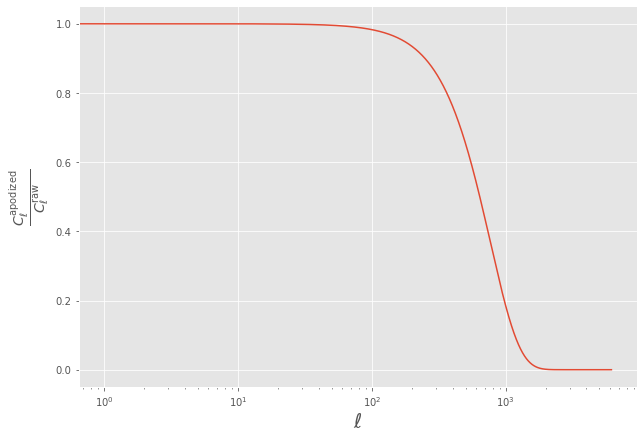

In [10]:
plt.figure(figsize=(10, 7))
plt.semilogx(cl_gal_apodized/cl_gal)
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm apodized}_{\ell}}{C^{\rm raw}_{\ell}}$", fontsize = 20)

Rotate apodized mask in $a_{\ell m}$ space

In [11]:
#rotate from Eq. Coord. to Gal. Coord to match Planck 
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask_eq_apodized = r.rotate_map_alms(planck_mask_gal_apodized, 
                                    lmax=3 * hp.get_nside(planck_mask_gal_apodized) - 1)

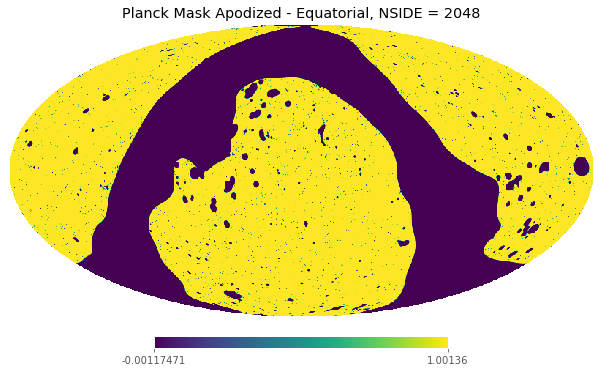

In [12]:
hp.mollview(planck_mask_eq_apodized, title = "Planck Mask Apodized - Equatorial, NSIDE = 2048")

In [13]:
cl_eq_apodized = hp.anafast(planck_mask_eq_apodized, pol = False)
cl_eq_apodized_forced = hp.anafast(np.clip(planck_mask_eq_apodized, a_min=0., a_max=1.), pol = False)

Text(0.5, 1.0, 'Ratio of power spectra of apodized maps - Equatorial forced')

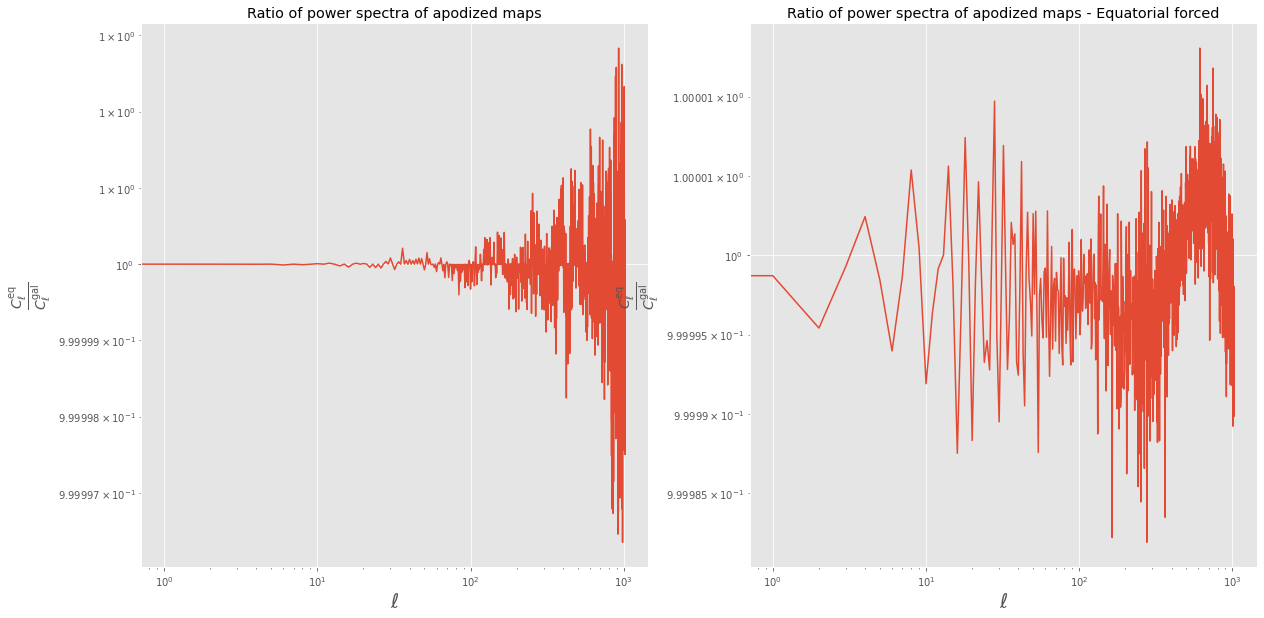

In [15]:
fg, ax = plt.subplots(ncols=2, figsize=(20, 10))
fg.subplots_adjust(wspace=0.2)

plt.sca(ax[0])
plt.loglog((cl_eq_apodized/cl_gal_apodized)[:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq}_{\ell}}{C^{\rm gal}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")

plt.sca(ax[1])
plt.loglog((cl_eq_apodized_forced/cl_gal_apodized)[:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq}_{\ell}}{C^{\rm gal}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps - Equatorial forced")

Degrade apodized equatorial mask to `NSIDE = 1024`

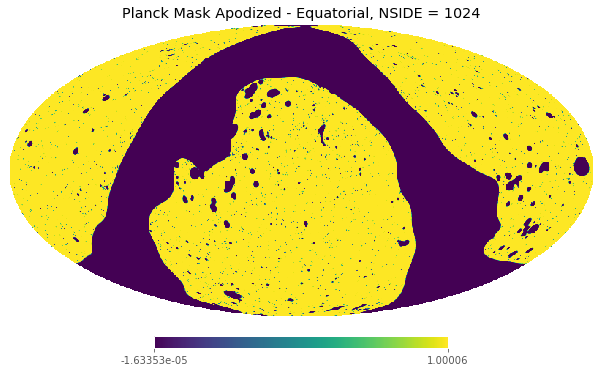

In [16]:
planck_mask_eq_apodized_1024 = hp.ud_grade(planck_mask_eq_apodized.astype(float), nside_out=NSIDE_OUT).astype(float)
hp.mollview(planck_mask_eq_apodized_1024, title = "Planck Mask Apodized - Equatorial, NSIDE = 1024")

In [17]:
cl_eq_apodized_1024 = hp.anafast(planck_mask_eq_apodized_1024, pol = False, lmax=3*NSIDE_OUT - 1)
cl_eq_apodized_forced_1024 = hp.anafast(np.clip(planck_mask_eq_apodized_1024, a_min=0., a_max=1.), 
                                        pol = False, lmax=3*NSIDE_OUT-1)

Text(0.5, 1.0, 'Ratio of power spectra of apodized maps - Equatorial forced')

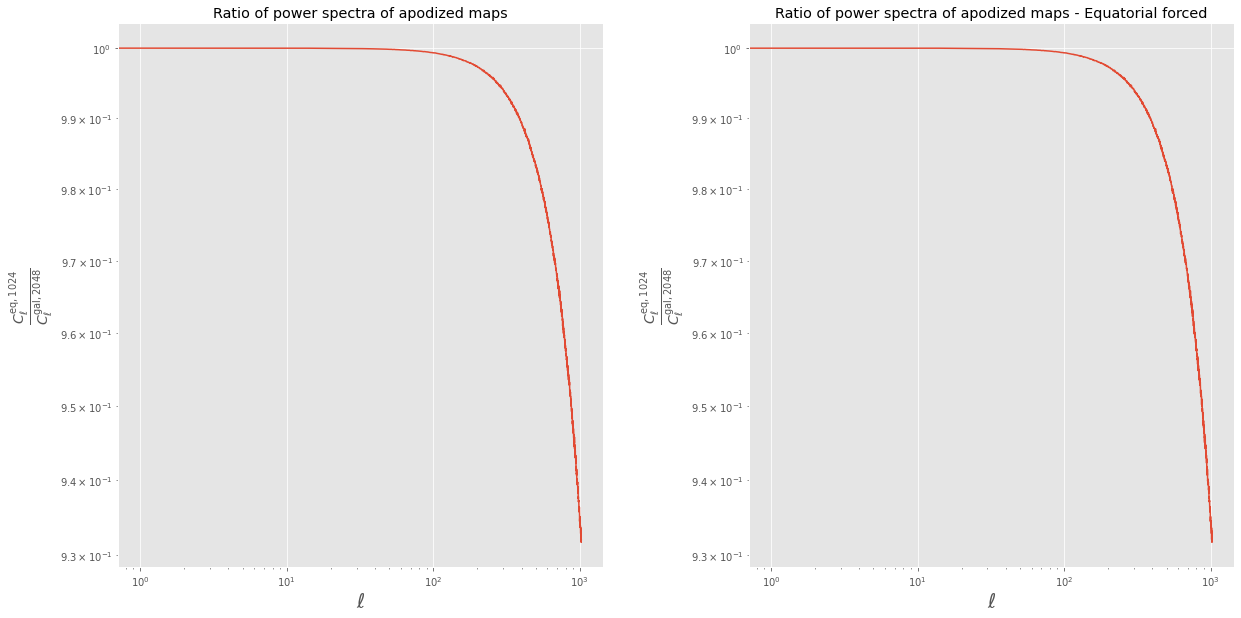

In [22]:
fg, ax = plt.subplots(ncols=2, figsize=(20, 10))
fg.subplots_adjust(wspace=0.3)

plt.sca(ax[0])
plt.loglog(cl_eq_apodized_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")

plt.sca(ax[1])
plt.loglog(cl_eq_apodized_forced_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps - Equatorial forced")

## Test effect of `hp.ud_grade` on power spectrum

In [23]:
planck_mask_gal_1024 = hp.ud_grade(planck_mask_gal, nside_out=NSIDE_OUT)

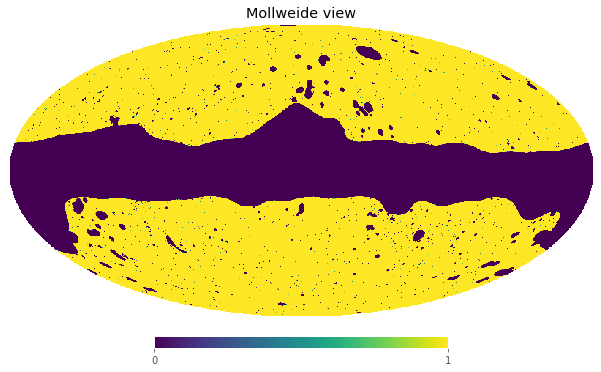

In [24]:
hp.mollview(planck_mask_gal_1024)

In [25]:
cl_gal_1024 = hp.anafast(planck_mask_gal_1024, pol = False)

Text(0, 0.5, '$\\frac{C_{\\rm gal, 1024}}{C_{\\rm gal, 2048}}$')

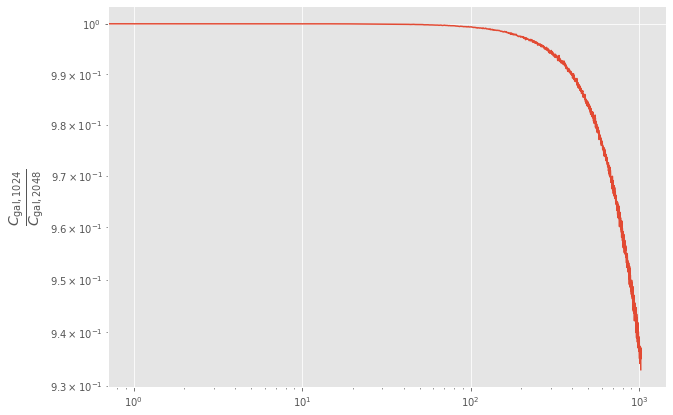

In [28]:
plt.figure(figsize=(10, 7))
plt.loglog(cl_gal_1024[:NSIDE_OUT]/cl_gal[:NSIDE_OUT])
plt.ylabel(r"$\frac{C_{\rm gal, 1024}}{C_{\rm gal, 2048}}$", fontsize = 20)

Text(0, 0.5, '$\\frac{C_{\\rm gal, 1024}}{C_{\\rm gal, 2048}}$')

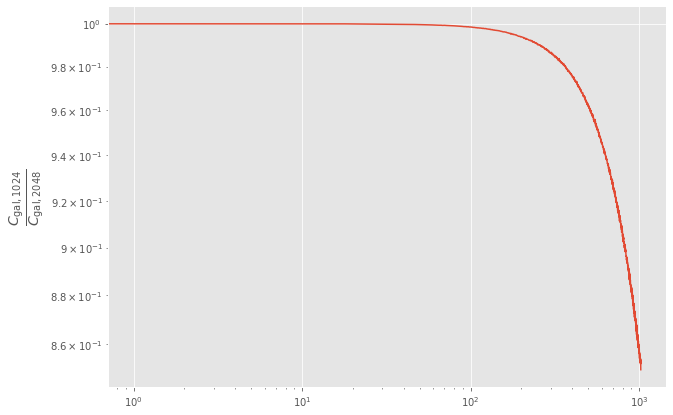

In [47]:
plt.figure(figsize=(10, 7))
plt.loglog((cl_gal_1024[:NSIDE_OUT]*(hp.pixwin(nside=NSIDE_OUT)**2)[:NSIDE_OUT])/(cl_gal[:NSIDE_OUT]))
plt.ylabel(r"$\frac{C_{\rm gal, 1024}}{C_{\rm gal, 2048}}$", fontsize = 20)

### Test impact of NSIDE on $C_{\ell}$ with pure signal

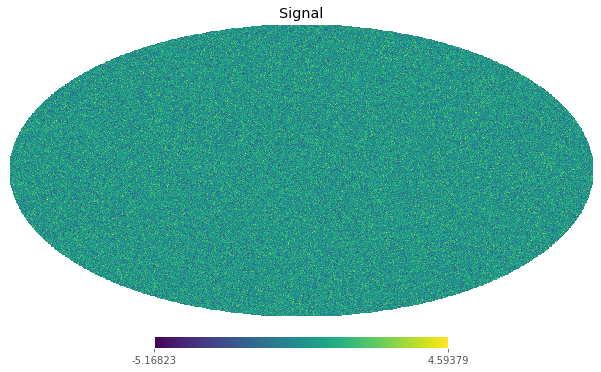

In [48]:
npix = hp.nside2npix(2048)

np.random.seed(12)
signal = np.random.normal(size=npix)

hp.mollview(signal, title="Signal")

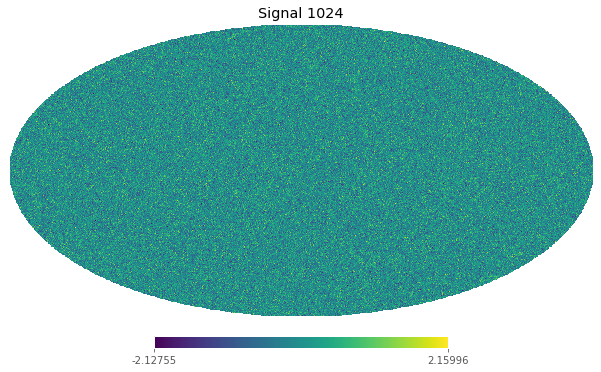

In [49]:
signal_1024 = hp.ud_grade(signal, nside_out=1024)
hp.mollview(signal_1024, title="Signal 1024")

In [50]:
tmpcl_2048 = hp.anafast(signal, pol=False)
tmpcl_1024 = hp.anafast(signal_1024, pol=False)

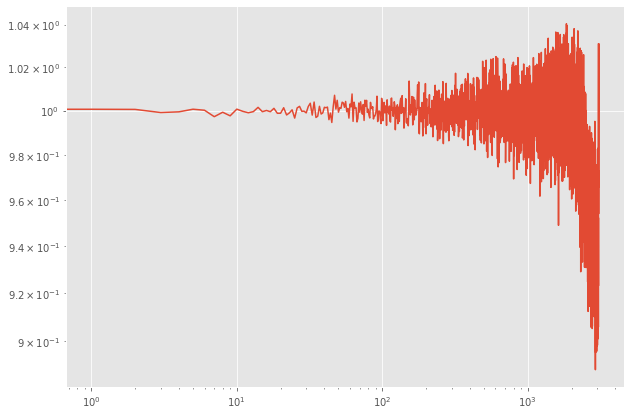

In [51]:
plt.figure(figsize=(10,7))
plt.loglog(tmpcl_1024/tmpcl_2048[:3*1024])

## Transformation without Apodization

In [79]:
planck_mask_gal = hp.fitsfunc.read_map("../dat/planck-lensing-mask.fits") 
planck_mask_gal_1024 = hp.ud_grade(planck_mask_gal, nside_out= 1024) #convert mask from 2048 to 1024
#rotate from Eq. Coord. to Gal. Coord to match Planck 
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask = r.rotate_map_alms(planck_mask_gal, lmax = LMAX_OUT)
#planck_mask = np.clip(planck_mask, a_min=0., a_max=1.)

#legacy surveys mask
#ls_elg_rand = np.load("../../imaging-sys-covariance/dat/elg_ran1024.npy")
#ls_mask = deepcopy(ls_elg_rand)
#ls_mask[ls_mask > 0] = 1 #set good pixels to 1
#del ls_elg_rand

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Plot masks

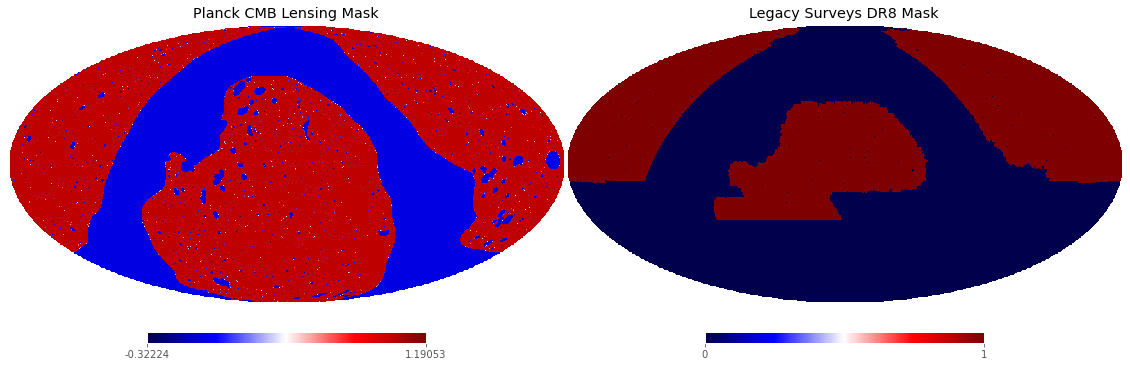

In [75]:
fg, ax = plt.subplots(ncols=2, figsize=(20, 10))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(planck_mask, title = "Planck CMB Lensing Mask", hold = True, cmap = 'seismic')

plt.sca(ax[1])
hp.mollview(ls_mask, title = "Legacy Surveys DR8 Mask", hold = True, cmap = 'seismic')

**Q: What are the different non-zero values of mask in Planck?**

Check how much mask degrades due to changing into new basis

In [76]:
planck_mask_gal[planck_mask_gal > 0].size/planck_mask[planck_mask > 0].size

0.8043767573666415

Check change in power spectrum

In [77]:
cl_eq = hp.anafast(planck_mask, lmax = 3 * 1024, pol = False)
cl_gal = hp.anafast(planck_mask_gal, lmax = 3 * 1024, pol = False)

Text(0, 0.5, '$\\frac{C^{\\rm gal}_{\\ell}}{C^{\\rm eq}_{\\ell}}$')

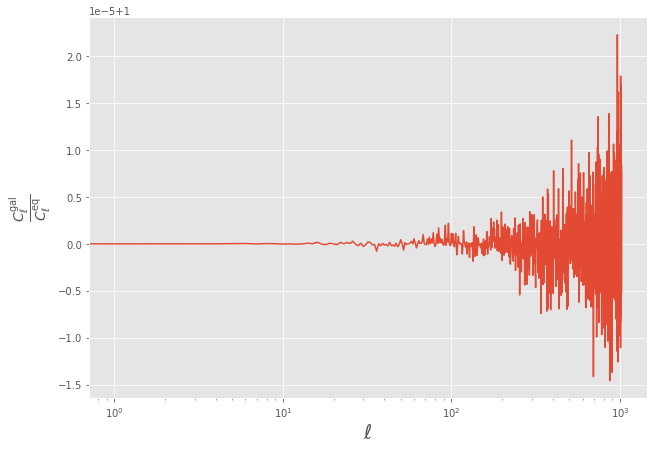

In [78]:
plt.figure(figsize=(10, 7))
plt.semilogx(np.arange(0, 1024), (cl_gal/cl_eq)[:1024])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm gal}_{\ell}}{C^{\rm eq}_{\ell}}$", fontsize = 20)

## Convert Planck mask properly without interpolation

Convert center of each pixel into galactic coordinate system 

In [26]:
#find the pixel centre ra and dec for each pixel
npix = hp.nside2npix(1024)
ra = np.zeros(npix)
dc = np.zeros(npix)

for i in range(npix):
    ra[i], dc[i] = hp.pix2ang(nside=1024, ipix=i, lonlat=True)

In [23]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [28]:
c_gal = SkyCoord(l=ra*u.degree, b=dc*u.degree, frame='galactic')

In [29]:
c_icrs = c_gal.icrs

In [35]:
c_icrs.ra.value

array([192.90968028, 192.84874132, 192.80928409, ...,  12.8702059 ,
        12.90968028,  12.84874132])

In [37]:
ipix_equatorial = hp.ang2pix(nside=1024, theta=c_icrs.ra.value, phi = c_icrs.dec.value, lonlat=True)

In [46]:
u, c = np.unique(ipix_equatorial, return_counts=True)
dup = u[c > 1]

In [56]:
ipix_equatorial

array([3420307, 3420306, 3424401, ..., 9156754, 9160851, 9160850])

In [52]:
dup

array([       9,       12,       14, ..., 12582894, 12582896, 12582901])

In [57]:
np.where(ipix_equatorial == 12582894)

(array([9147767, 9151862]),)

In [58]:
ipix_equatorial[9147767]

12582894

In [59]:
ipix_equatorial[9151862]

12582894

Convert using healpy

In [27]:
hp.Rotator(coord='ge', deg=True)(ra[0], dc[0])

array([0.26599739, 1.77274742])

In [22]:
l, b = r(ra, dc, deg = True)

In [24]:
l.min()

0.0008696905529589142

Combine masks

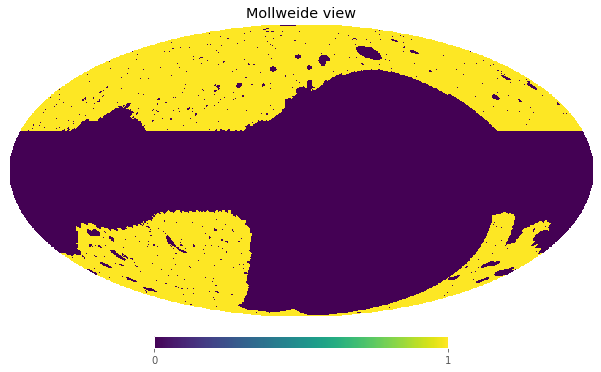

In [26]:
#Logical combine two masks to get overlaps
mask_combined = np.logical_and(planck_mask, ls_mask)

hp.mollview(mask_combined)

In [25]:
np.save("../dat/planck+dr8-mask.npy", mask_combined, allow_pickle=False)

## f$_{\rm sky}$ statistics for each mask

In [27]:
ls_mask.sum()/ls_mask.size

0.385480801264445

In [28]:
planck_mask[planck_mask > 0].size/planck_mask.size

0.6728666623433431

In [29]:
mask_combined.sum()/mask_combined.size

0.3706253369649251

## Compare mask power spectrum in original vs rotated space

In [30]:
ls_mask_eq = deepcopy(ls_elg_rand)
ls_mask_eq[ls_mask_eq > 0] = 1

In [39]:
cl_eq = hp.anafast(ls_mask_eq, lmax = 3 * 1024, pol = False)
cl_gal = hp.anafast(ls_mask, lmax = 3 * 1024, pol = False)

Text(0, 0.5, '$\\frac{C^{\\rm gal}_{\\ell}}{C^{\\rm eq}_{\\ell}}$')

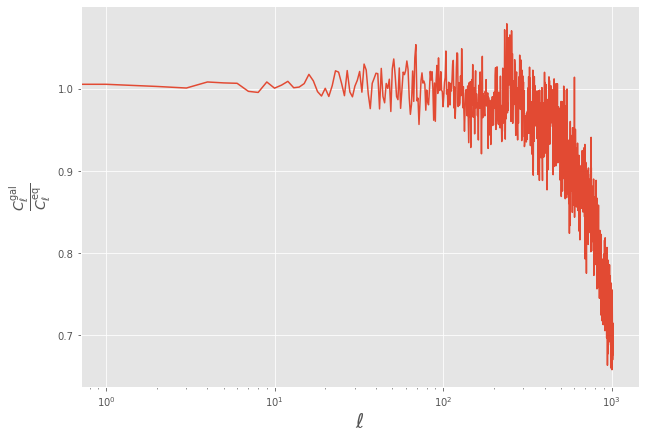

In [45]:
plt.figure(figsize=(10, 7))
plt.semilogx(np.arange(0, 1024), (cl_gal/cl_eq)[:1024])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm gal}_{\ell}}{C^{\rm eq}_{\ell}}$", fontsize = 20)